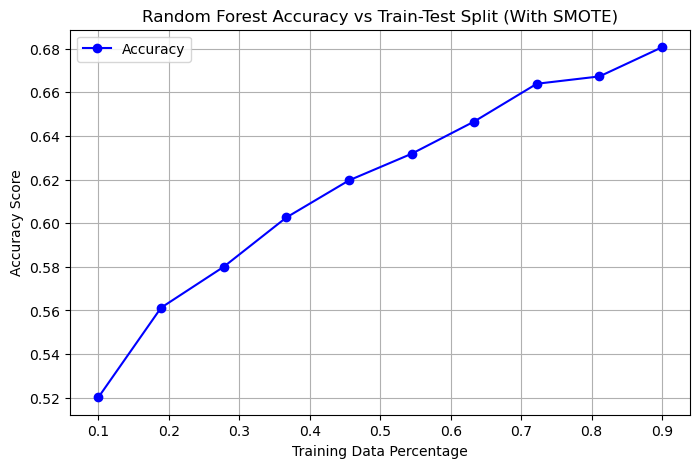


✅ Model and vectorizer saved successfully!


In [ ]:
# 📌 Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import spacy
from heapq import nlargest
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter

# --- Load Dataset ---
df = pd.read_csv('Updated_Review_db3.csv', dtype=str, low_memory=False)

# Drop missing values
df = df.dropna(subset=['City', 'Place', 'Review', 'Rating'])

# Convert Rating to numeric
df['Rating'] = df['Rating'].astype(float)

# 🔹 **Filter Out Rare Ratings (Less Than 2 Samples)**
rating_counts = df['Rating'].value_counts()
valid_ratings = rating_counts[rating_counts >= 2].index
df = df[df['Rating'].isin(valid_ratings)]

# 🔹 **Sort by Rating (Descending)**
df = df.sort_values(by="Rating", ascending=False)

# --- Feature Extraction using TF-IDF ---
vectorizer = TfidfVectorizer(stop_words='english', max_features=20000, ngram_range=(1,3))
X = vectorizer.fit_transform(df['Review'])
y = df['Rating']

# --- Apply SMOTE (Better Handling of Imbalance) ---
smote = SMOTE(sampling_strategy="auto", k_neighbors=3, random_state=42)  # Balanced setting
X_resampled, y_resampled = smote.fit_resample(X, y)

# 🔹 **Check Resampled Distribution**
resampled_counts = pd.Series(y_resampled).value_counts()

# --- Load spaCy Model ---
nlp = spacy.load("en_core_web_sm")

# --- Faster Processing: Use `.pipe()` Instead of Loop ---
def extract_summary_spacy(text, num_sentences=8):
    """Summarizes a given text using word frequency scoring in spaCy."""
    if not text or len(text.split()) < num_sentences:  # Return as-is if too short
        return text

    doc = nlp(text)

    # Compute word frequencies (excluding stopwords & punctuation)
    word_frequencies = Counter(
        token.text.lower() for token in doc if token.text.lower() not in STOP_WORDS and token.is_alpha
    )

    # Normalize frequencies
    max_freq = max(word_frequencies.values(), default=1)
    for word in word_frequencies:
        word_frequencies[word] /= max_freq

    # Score sentences based on word importance
    sentence_scores = {
        sent: sum(word_frequencies.get(token.text.lower(), 0) for token in sent) for sent in doc.sents
    }

    # Get top sentences (handle cases with fewer sentences)
    num_sentences = min(num_sentences, len(doc.sents))
    top_sentences = nlargest(num_sentences, sentence_scores, key=sentence_scores.get)
    return " ".join([sent.text for sent in top_sentences])

# 🔥 **Optimized Processing Using `.pipe()`**
df['Description'] = list(nlp.pipe(df['Review'], batch_size=100))

# --- Define different training sizes ---
train_sizes = np.linspace(0.1, 0.9, 10)  # Training percentages
accuracies = []

# --- Model Training ---
for train_size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, train_size=train_size, random_state=42
    )

    # Train the optimized model
    model = RandomForestClassifier(
        n_estimators=300, max_depth=20, min_samples_split=5,
        min_samples_leaf=3, class_weight="balanced", random_state=42
    )
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# --- 📊 Plot 1: Accuracy vs Train-Test Split ---
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, accuracies, marker='o', linestyle='-', color='b', label="Accuracy")
plt.xlabel("Training Data Percentage")
plt.ylabel("Accuracy Score")
plt.title("Random Forest Accuracy vs Train-Test Split (With SMOTE)")
plt.legend()
plt.grid(True)
plt.show()

# --- Final Model Training (Full Resampled Data) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- Save Model and Vectorizer ---
with open("location_recommendation_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("\n✅ Model and vectorizer saved successfully!")


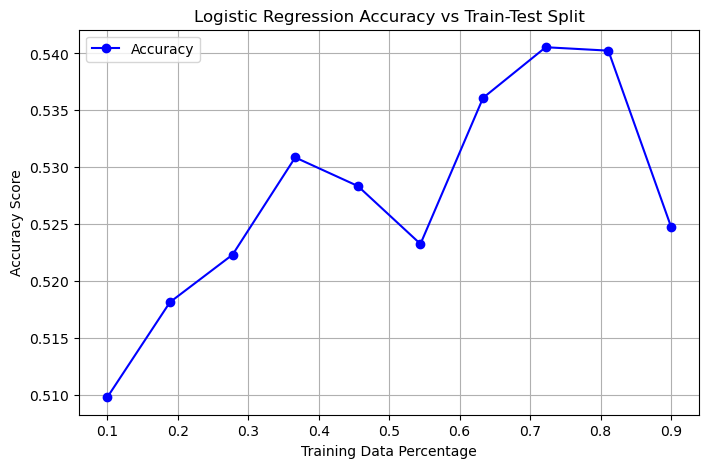

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# --- Load Dataset ---
df = pd.read_csv('Updated_Review_db3.csv', dtype=str, low_memory=False)

# Drop missing values
df = df.dropna(subset=['City', 'Place', 'Review', 'Rating'])

# Convert ratings to numerical values
df['Rating'] = df['Rating'].astype(float)

# --- Convert Ratings into Classes ---
def classify_rating(rating):
    if rating <= 4.0:
        return 0  # Low Rating
    elif 4.<= rating <= 8:
        return 1  # Medium Rating
    else:
        return 2  # High Rating

df['Rating_Class'] = df['Rating'].apply(classify_rating)

# --- Feature Extraction using TF-IDF ---
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['Review'])

# Target variable (Rating Classes)
y = df['Rating_Class']

# --- Experiment with Different Train-Test Splits ---
train_sizes = np.linspace(0.1, 0.9, 10)  # Different train-test splits
accuracies = []

for train_size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
    
    # Train Logistic Regression Model
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)
    
    # Predict and compute accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# --- Plot Accuracy vs Train-Test Split ---
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, accuracies, marker='o', linestyle='-', color='b', label="Accuracy")

plt.xlabel("Training Data Percentage")
plt.ylabel("Accuracy Score")
plt.title("Logistic Regression Accuracy vs Train-Test Split")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
